# CNN autoencoder

## 1 Library packages

In [23]:
import numpy as np
import pandas as pd
import random
from pandas import read_csv
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

def make_windows(
  arr,
  win_size,
  step_size,
):
  w_list = list()
  n_records = arr.shape[0]
  remainder = (n_records - win_size) % step_size 
  num_windows = 1 + int((n_records - win_size - remainder) / step_size)
  for k in range(num_windows):
    w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
  return np.array(w_list)

def load_file(filepath):
    dataframe = read_csv(filepath, header = None)
    return dataframe.values

## 2 Load Data

In [24]:
GRFx = load_file('Data/GRFx.csv')# [:, 1:1301]
GRFy = load_file('Data/GRFy.csv')
GRFz = load_file('Data/GRFz.csv')

### 2.1 Check maximum count of time series data

In [25]:
# find maximum count of non-zero values for each time series
print(np.count_nonzero(GRFx, axis = 1).max())
print(np.count_nonzero(GRFy, axis = 1).max())
print(np.count_nonzero(GRFz, axis = 1).max())
GRFx = GRFx[:, range(1300)]
GRFy = GRFy[:, range(1300)]
GRFz = GRFz[:, range(1300)]

1300
1300
1300


## 3 Reconstruct data with 50% overlapping


In [26]:
# transfrom GRFx
obs_range = range(GRFx.shape[0])
GRFx_re = np.zeros((GRFx.shape[0], 51, 50, 1))
for i in obs_range:
    tmp1 = make_windows(GRFx[i, :], 50, 25)
    tmp2 = tmp1.reshape(51, 50, -1)
    GRFx_re[i] = tmp2

### 3.1 Check if the transformation is good

In [27]:
print('transformed data: \n', GRFx_re[0, 0, range(5), :])
print('raw data: ', GRFx[0, range(5)])

transformed data: 
 [[-4.029]
 [-3.471]
 [-2.999]
 [-2.514]
 [-1.72 ]]
raw data:  [-4.029 -3.471 -2.999 -2.514 -1.72 ]


### 3.1 Visualize picture

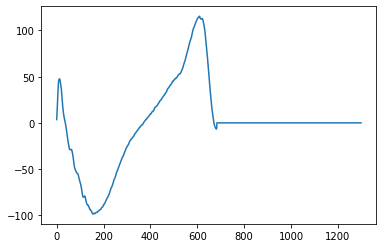

In [28]:
img_plot = plt.plot(GRFx[900, :])

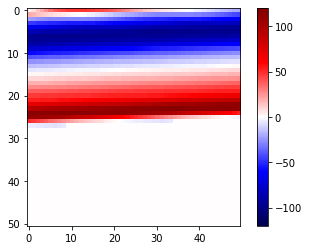

In [29]:
img_re_plot = plt.imshow(GRFx_re[900, :, :, 0], 
                         vmin = -120, 
                         vmax = 120, 
                         cmap='seismic')
plt.colorbar()

## 4 Build 2D CNN autoencoder

In [30]:
print('shape of newdata =', GRFx_re.shape)

shape of newdata = (15696, 51, 50, 1)


<Figure size 432x288 with 0 Axes>

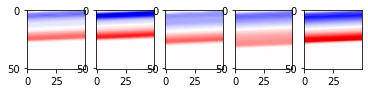

In [31]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,5) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
    axarr[i].imshow(GRFx_re[random.randint(0, 15696)], 
                    vmin = -400, 
                    vmax = 400, 
                    cmap='seismic')

### 4.1 Model Creation

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(GRFx_re, GRFx, test_size = 0.2, random_state = 1)
print(X_train.shape)
print(Y_train.shape)

(12556, 51, 50, 1)
(12556, 1300)


In [33]:
cnn2d_encoder = Sequential([
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', 
          input_shape = (51, 50, 1)), 
    MaxPooling2D((2, 2)), 
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'), 
    MaxPooling2D((2, 2)), 
    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)), 
    Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)), 
    Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)), 
    Flatten()
])
cnn2d_decoder = Sequential([
    Dense(32, activation = 'relu', input_shape = (cnn2d_encoder.output.shape[1], )), 
    Dense(128, activation = 'relu'),
    Dense(512, activation = 'relu'), 
    Dense(1300, activation=None) # output layer
])
cnn2d_autoencoder = Model(inputs = cnn2d_encoder.input, outputs = cnn2d_decoder(cnn2d_encoder.output))
cnn2d_autoencoder.compile(loss='mse', optimizer='adam', metrics = ['mae'])
cnn2d_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLayer  [(None, 51, 50, 1)]      0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 50, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                           

In [34]:
es = EarlyStopping(monitor = 'val_loss', 
                  mode = 'min', 
                  verbose = 1, 
                  patience = 10)
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
model_history = cnn2d_autoencoder.fit(X_train, Y_train, 
                                epochs=200, 
                                batch_size=64, 
                                validation_split = .2, 
                                verbose=1,
                                callbacks = [es, mc]
                                     )

Epoch 1/200
157/157 [==============================] - 5s 30ms/step - loss: 664.2136 - mae: 13.8913 - val_loss: 190.5640 - val_mae: 8.1940
Epoch 2/200
157/157 [==============================] - 5s 31ms/step - loss: 139.5145 - mae: 7.0183 - val_loss: 115.7659 - val_mae: 6.2287
Epoch 3/200
157/157 [==============================] - 5s 30ms/step - loss: 98.7855 - mae: 5.8127 - val_loss: 84.2146 - val_mae: 5.4454
Epoch 4/200
157/157 [==============================] - 5s 30ms/step - loss: 73.6493 - mae: 5.0579 - val_loss: 72.1193 - val_mae: 4.9591
Epoch 5/200
157/157 [==============================] - 5s 30ms/step - loss: 67.9326 - mae: 4.8568 - val_loss: 65.1930 - val_mae: 4.6888
Epoch 6/200
157/157 [==============================] - 5s 31ms/step - loss: 59.5274 - mae: 4.5502 - val_loss: 53.6825 - val_mae: 4.2538
Epoch 7/200
157/157 [==============================] - 5s 30ms/step - loss: 50.5380 - mae: 4.1391 - val_loss: 49.5120 - val_mae: 4.0179
Epoch 8/200
157/157 [======================

157/157 [==============================] - 5s 31ms/step - loss: 29.8172 - mae: 3.0241 - val_loss: 30.0241 - val_mae: 2.9310
Epoch 29/200
157/157 [==============================] - 5s 30ms/step - loss: 28.5800 - mae: 2.9315 - val_loss: 29.8293 - val_mae: 2.9529
Epoch 30/200
157/157 [==============================] - 5s 30ms/step - loss: 28.6861 - mae: 2.9516 - val_loss: 28.6328 - val_mae: 2.8761
Epoch 31/200
157/157 [==============================] - 5s 30ms/step - loss: 28.0184 - mae: 2.9224 - val_loss: 29.1647 - val_mae: 2.9244
Epoch 32/200
157/157 [==============================] - 5s 31ms/step - loss: 27.4681 - mae: 2.8750 - val_loss: 29.9805 - val_mae: 3.0047
Epoch 33/200
157/157 [==============================] - 5s 30ms/step - loss: 27.0453 - mae: 2.8606 - val_loss: 28.2880 - val_mae: 2.9299
Epoch 34/200
157/157 [==============================] - 5s 31ms/step - loss: 27.6852 - mae: 2.9420 - val_loss: 29.1138 - val_mae: 3.0321
Epoch 35/200
157/157 [==============================] 

Epoch 56/200
157/157 [==============================] - 5s 30ms/step - loss: 19.5331 - mae: 2.5809 - val_loss: 20.9032 - val_mae: 2.6884
Epoch 57/200
157/157 [==============================] - 5s 30ms/step - loss: 19.5018 - mae: 2.5851 - val_loss: 21.1490 - val_mae: 2.6940
Epoch 58/200
157/157 [==============================] - 5s 30ms/step - loss: 19.3359 - mae: 2.5691 - val_loss: 19.9802 - val_mae: 2.5920
Epoch 59/200
157/157 [==============================] - 5s 30ms/step - loss: 19.3391 - mae: 2.5769 - val_loss: 19.7297 - val_mae: 2.5502
Epoch 60/200
157/157 [==============================] - 5s 31ms/step - loss: 19.3050 - mae: 2.5683 - val_loss: 22.9206 - val_mae: 2.8355
Epoch 61/200
157/157 [==============================] - 5s 30ms/step - loss: 19.1624 - mae: 2.5530 - val_loss: 20.0993 - val_mae: 2.5752
Epoch 62/200
157/157 [==============================] - 5s 30ms/step - loss: 19.3928 - mae: 2.5825 - val_loss: 20.1770 - val_mae: 2.6088
Epoch 63/200
157/157 [===================

In [35]:
result_2dcnn = cnn2d_autoencoder.predict(X_test)
latent_2dcnn = cnn2d_encoder.predict(X_test)

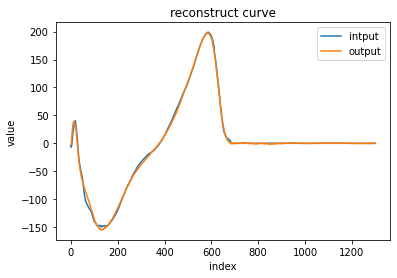

In [36]:
# reconstruct_test[1, :]
i = 1
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(Y_test[i, :], label='intput')
plt.plot(result_2dcnn[i, :], label='output')
plt.legend()
plt.show()

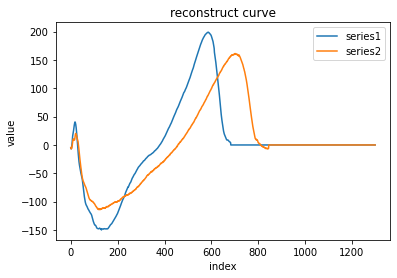

In [37]:
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(Y_test[1, :], label='series1')
plt.plot(Y_test[2, :], label='series2')
plt.legend()
plt.show()

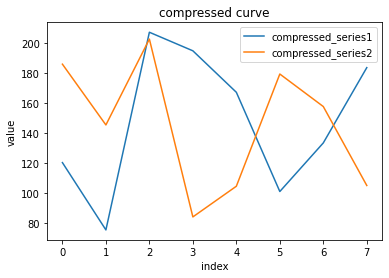

In [38]:
plt.title('compressed curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(latent_2dcnn[i, :], label='compressed_series1')
plt.plot(latent_2dcnn[2, :], label='compressed_series2')
plt.legend()
plt.show()

## 5 Build 1D CNN autoencoder

In [9]:
GRFx_1d = GRFx_re.reshape(15696, 51, 50)
print('shape of newdata =', GRFx_1d.shape)
X_train, X_test, Y_train, Y_test = train_test_split(GRFx_1d, GRFx, test_size = 0.2, random_state = 1)
print(X_train.shape)
print(Y_train.shape)

shape of newdata = (15696, 51, 50)
(12556, 51, 50)
(12556, 1300)


In [62]:
cnn1d_encoder = Sequential([
    Conv1D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (51, 50)), 
    MaxPooling1D(pool_size = 2),
    Conv1D(filters = 64, kernel_size = 3, activation = 'relu'), 
    # Dropout(0.5), 
    MaxPooling1D(pool_size = 2), 
    Conv1D(filters = 18, kernel_size = 3, activation = 'relu'), 
    MaxPooling1D(pool_size = 2), 
    Flatten()
])
cnn1d_decoder = Sequential([
    Dense(64, activation = 'relu', input_shape = (cnn1d_encoder.output.shape[1], )), 
    Dense(128, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(1300, activation = None)
])
cnn1d_autoencoder = Model(inputs = cnn1d_encoder.input, outputs = cnn1d_decoder(cnn1d_encoder.output))
cnn1d_autoencoder.compile(loss='mse', optimizer='adam', metrics = ['mae'])
cnn1d_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12_input (InputLayer  [(None, 51, 50)]         0         
 )                                                               
                                                                 
 conv1d_12 (Conv1D)          (None, 49, 128)           19328     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 24, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 22, 64)            24640     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 11, 64)           0         
 g1D)                                                            
                                                          

In [63]:
es = EarlyStopping(monitor = 'val_loss', 
                  mode = 'min', 
                  verbose = 1, 
                  patience = 10)
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
model_history2 = cnn1d_autoencoder.fit(X_train, Y_train, 
                                epochs=200, 
                                batch_size=32, 
                                validation_split = .2, 
                                verbose=1,
                                callbacks = [es, mc])

Epoch 1/200
314/314 [==============================] - 2s 6ms/step - loss: 250.0389 - mae: 8.2894 - val_loss: 75.5929 - val_mae: 5.1442
Epoch 2/200
314/314 [==============================] - 2s 5ms/step - loss: 49.4537 - mae: 4.1612 - val_loss: 39.9770 - val_mae: 3.6410
Epoch 3/200
314/314 [==============================] - 2s 5ms/step - loss: 35.1008 - mae: 3.4258 - val_loss: 32.6173 - val_mae: 3.2262
Epoch 4/200
314/314 [==============================] - 2s 5ms/step - loss: 29.8373 - mae: 3.0984 - val_loss: 28.1581 - val_mae: 2.9462
Epoch 5/200
314/314 [==============================] - 2s 5ms/step - loss: 25.0673 - mae: 2.7834 - val_loss: 27.9420 - val_mae: 2.9587
Epoch 6/200
314/314 [==============================] - 2s 5ms/step - loss: 23.8880 - mae: 2.7051 - val_loss: 23.2828 - val_mae: 2.5816
Epoch 7/200
314/314 [==============================] - 2s 5ms/step - loss: 22.5779 - mae: 2.6110 - val_loss: 24.8199 - val_mae: 2.7847
Epoch 8/200
314/314 [==============================] -

314/314 [==============================] - 2s 5ms/step - loss: 9.2988 - mae: 1.7993 - val_loss: 8.3480 - val_mae: 1.6654
Epoch 29/200
314/314 [==============================] - 2s 5ms/step - loss: 8.2489 - mae: 1.6927 - val_loss: 8.9008 - val_mae: 1.7146
Epoch 30/200
314/314 [==============================] - 2s 5ms/step - loss: 9.1787 - mae: 1.7819 - val_loss: 10.2001 - val_mae: 1.9464
Epoch 31/200
314/314 [==============================] - 2s 5ms/step - loss: 7.7769 - mae: 1.6498 - val_loss: 9.6706 - val_mae: 1.9019
Epoch 32/200
314/314 [==============================] - 2s 5ms/step - loss: 7.7739 - mae: 1.6441 - val_loss: 13.3630 - val_mae: 2.1814
Epoch 33/200
314/314 [==============================] - 2s 5ms/step - loss: 7.5926 - mae: 1.6346 - val_loss: 7.4056 - val_mae: 1.5509
Epoch 34/200
314/314 [==============================] - 2s 5ms/step - loss: 7.8818 - mae: 1.6423 - val_loss: 8.1988 - val_mae: 1.6586
Epoch 35/200
314/314 [==============================] - 2s 5ms/step - los

In [65]:
result_1dcnn = cnn1d_autoencoder.predict(X_test)
latent_1dcnn = cnn1d_encoder.predict(X_test)

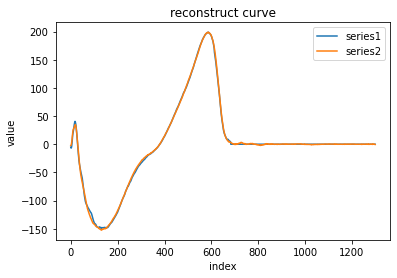

In [71]:
# reconstruct_test[1, :]
i = 1
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(Y_test[i, :], label='intput')
plt.plot(result_1dcnn[i, :], label='output')
plt.legend()
plt.show()

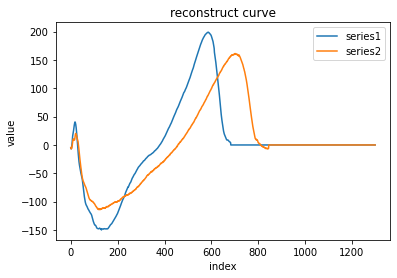

In [73]:
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(Y_test[1, :], label='series1')
plt.plot(Y_test[2, :], label='series2')
plt.legend()
plt.show()

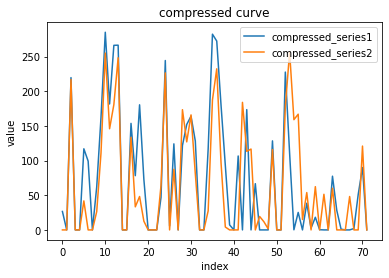

In [74]:
plt.title('compressed curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(latent_1dcnn[i, :], label='compressed_series1')
plt.plot(latent_1dcnn[2, :], label='compressed_series2')
plt.legend()
plt.show()

## 6 Save Models and Results

### 6.1 Save test data and prediction results

In [12]:
# np.savetxt('Results/test_data.csv',Y_test,delimiter=",")
test = load_file('Results/test_data.csv')

In [16]:
# np.savetxt('Results/result_1dcnn.csv',result_1dcnn,delimiter=",")
# np.savetxt('Results/result_2dcnn_new.csv',result_2dcnn,delimiter=",")

### 6.2 Save latent space results

In [17]:
# np.savetxt('Results/latent_1dcnn.csv',latent_1dcnn,delimiter=",")
# np.savetxt('Results/latent_2dcnn_new.csv',latent_2dcnn,delimiter=",")

### 6.3 Save models

In [18]:
# cnn1d_autoencoder.save("Results/cnn1d_autoencoder.h5", include_optimizer=True)
# cnn2d_autoencoder.save("Results/cnn2d_autoencoder_new.h5", include_optimizer=True)

In [3]:
from tensorflow import keras
model = keras.models.load_model("Results/cnn1d_autoencoder.h5")

In [11]:
pred = model.predict(X_test)

#### 6.3.1 Check if the model saving is good

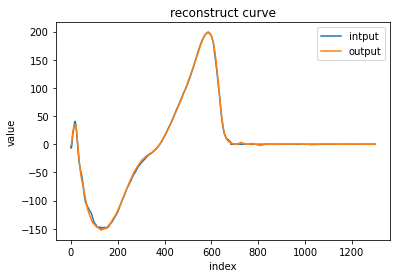

In [13]:
i = 1
plt.title('reconstruct curve')
plt.xlabel('index')
plt.ylabel('value')
plt.plot(test[i, :], label='intput')
plt.plot(pred[i, :], label='output')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error as mae
mae(Y_test,result_2dcnn)

2.5981800012796605